In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [49]:
df = pd.read_csv("train.csv", index_col=0)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [50]:
#Filter feature data
X = df[["LotArea","YrSold"]]
# print(X)
X["YrSold"] = list(map(lambda year: year - 2006, df["YrSold"])) #example of remapping column values 
# print(list(X["YrSold"]))
X = X.values
y = df["SalePrice"].values
print(X)

[[ 8450     2]
 [ 9600     1]
 [11250     2]
 ...
 [ 9042     4]
 [ 9717     4]
 [ 9937     2]]


C:\Users\bartv\AppData\Local\Temp\ipykernel_2024\2656283179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["YrSold"] = list(map(lambda year: year - 2006, df["YrSold"])) #example of remapping column values


In [51]:
#Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

print(X_train.shape)

# X_train = X_train.reshape(-1, 2)
# print(X_train.shape)

X_test = X_test.reshape(-1, 1)

# "x_train size: " + str(X_train.size) + " y_train size: " + str(y_train.size) 



(1022, 2)


In [52]:
#Train LinearRegression model
reg = LinearRegression()
reg.fit(X_train, y_train)


LinearRegression()

In [53]:
#Evaluate results
X_test = X_test.reshape(-1, 2)
print(X_test.shape)
y_pred = reg.predict(X_test)
r_squared = reg.score(X_test, y_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean squared error: " + str(rmse))
print("root squared error: " + str(r_squared))




(438, 2)
Mean squared error: 73997.59929730068
root squared error: 0.06533789508194232


In [54]:
#Before evaluating on history, retrieve the history

history = pd.DataFrame(columns=["Attempt", "r_squared", "rmse"] );
try:
    history = pd.read_csv("history.csv")
    print("Found history.csv with rows amount: " + str(history.shape[0]))
except FileNotFoundError:
    print("history.csv not found, creating new one")
    history.to_csv('history.csv', index = False)


Found history.csv with rows amount: 8


   Attempt  r_squared     rmse
4      4.0   0.065338  73997.0
5      5.0   0.065338  73997.0
6      6.0   0.065338  73997.0
7      7.0   0.065338  73997.0
Current attempt:     Attempt  r_squared     rmse
8      8.0   0.065338  73997.0


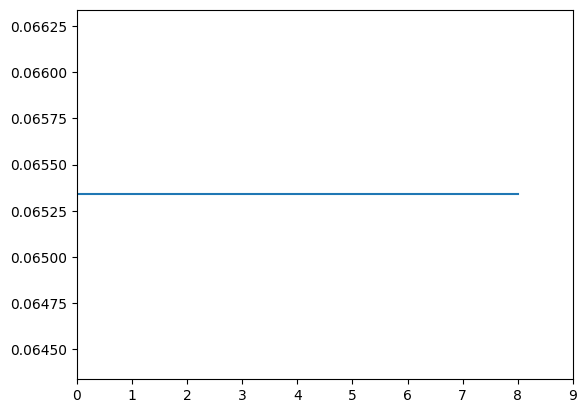

In [55]:
#Evaluate based on history and visualize progress


history.loc[len(history.index)] = [int(len(history.index)), r_squared, int(rmse)]
print(history[-5:-1])
print("Current attempt: ", history[-1:])
history.to_csv('history.csv', index = False)

plt.plot(history["Attempt"], history["r_squared"])
min_r_squared = np.min(history["r_squared"].values)
max_r_squared = np.max(history["r_squared"].values)

visual_margin = (max_r_squared - min_r_squared) * 0.5 + 0.001 #Makes the graph more eye friendly

plt.xlim(0, np.size(history["Attempt"].values))
plt.ylim(min_r_squared - visual_margin, max_r_squared + visual_margin)
plt.show()
